# TIme depeNdent ConduiT flow neUral netwoRk Emulator (TINCTURE)

A collaboration between Ying Qi Wong, PhD and Ben Mullet

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [3]:
# Neural network model

class PDENeuralNet(tf.keras.Model):
  def __init__(self, n_inputs, n_outputs):
    super().__init__()
    
    self.n_inputs = n_inputs
    self.n_outputs = n_outputs
  
    self.nn_model = tf.keras.Sequential([
      Dense(100, activation=tf.nn.elu),
      Dense(100, activation=tf.nn.elu),
      Dense(40, activation=tf.nn.elu),
      Dense(30, activation=tf.nn.elu),
      Dense(10, activation=tf.nn.elu),
      Dense(self.n_outputs, activation=None), # No activation last layer matches PINN paper
    ])

    self(tf.zeros([1, self.n_inputs]))  # dummy call to build the model

  @tf.function
  def call(self, x):
    z = self.nn_model(x)
    return z

In [14]:
# Neural network parameters
N_INPUTS = 1
N_OUTPUTS = 2

# Hyper-parameters
N_QUERY = 100
N_ITER = 50000
N_DATA_STEPS = 2000


In [21]:
# DUMMY CODE FOR YING QI'S MODEL

def get_yq_conduit_vals(p, v, phi_g, m_b, A):
  """Get derived values, given the primary variables
  Input
    p: (Nx1) tf.tensor for pressure
    v: (Nx1) tf.tensor for velocity
    phi_g: (Nx1) tf.tensor for gas volume fraction
    m_b: (Nx1) tf.tensor for mole fraction of exsolved h2o
    A: dict of constants for computing conduit values
  Output
    derived_vals_dict: dict of (Nx1) tf.tensors for derived conduit values
  """
  
  # remove this once implemented
  raise NotImplementedError
  
  # Notes: 
  # - Tensors can (almost always) use the same operations as numpy
  #   arrays, so just code this like you were coding a function for 
  #   numpy arrays
  # - In the example code (below), the dict A contains scalar constants that are
  #   used for calculating the derived values. In practice, we can
  #   make this dict contain anything we want, like arrays of constants
  #   that are the same size as the primary variable arrays being passed in.
  #   This might be useful if some constants change between model runs, 
  #   like conduit radius.
  
  #####################################
  #
  #           YING QI'S CODE HERE
  #
  #####################################
  
  ## Final bit of code might look something like this.
  ## Basically collecting all the "dependent variables" in your paper Table 1
  
  #   derived_vals_dict = {
  #     "c1" : c1,
  #     "k_mag" : k_mag,
  #     ....
  #   }
  
  return derived_vals_dict
  
  

In [22]:


def get_optimzer(type="Adam"):
  """Sets up NN model optimizer"""
  lr = 2e-3
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [500], [lr, lr * 0.1])
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
  if type=="Adam":
    trainer = tf.keras.optimizers.Adam(lr_schedule)
  else:
    lr = 6e-7 #too high [2e-6] too low [2e-7] 7e-7 is OK
    lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
          [500], [lr, lr * 0.1])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
    trainer = tf.keras.optimizers.SGD(learning_rate = lr)
  return trainer

trainer = get_optimzer()

def get_conduit_vals(p, u, A):
  """Get derived values, given the primary variables
  Input
    p: (Nx1) tensor for pressure
    u: (Nx1) tensor for velocity
    A: dict of constants for computing conduit values
  Output
    (Nx1) tensors for derived conduit values
    
  """
  
  rhog = p # Nondimensionalized
  phi = 1/(1 + (1-A['x0'])/(A['x0'])*(A['delta']*rhog))
  rho = (1-phi+A['delta']*phi*rhog)
  
  post_frag = (tf.cast(phi > A['phi0'], phi.dtype))
  pre_frag = 1.0 - post_frag
  
  tau_turbulent = A['f0']*rho*u*u*A['L']/A['r']
  tau_viscous = 8/A['Re']*(u)
  
  tau = tau_turbulent*post_frag + tau_viscous*pre_frag
  
  rhog = p
  
  beta = 1/A['delta']*A['x0']/(1+A['x0'])*(rho/rhog)**2
  
  return phi, rho, tau, rhog, beta

def split_tensor(tensor):
  """Splits NxM tensor into M Nx1 dimensional tensors"""
  vectors = tf.unstack(tensor,axis=1)
  for v in vectors:
    yield v[:,None]
  
  
def simple_conduit_loss(y, outputs, dvdy, A, iteration):
  """Calculate the loss function"""
  
  # Split outputs from the neural network model
  p, u = split_tensor(outputs)
      
  # Retrieve gradients from the neural network model
  dpdy, dudy = dvdy

  # Get derived values
  # ********* Ying Qi: This is where your code would plug in *************
    
  phi, rho, tau, rhog, beta = get_conduit_vals(p, u, A)
  
  # **********************************************************************

  # Calculate "physics-informed" values for gradients
  # (These are the values that the gradients should take if they 
  # satisfy the governing equations)
  dpdy0 = -(tau+rho/A['Fr']**2)/(1-(u**2)*beta)
  dudy0 = -u/rho*beta*dpdy0
  
  # Start training by just trying to match the matlab output
  if iteration < N_DATA_STEPS:
    loss_p = tf.reduce_mean(tf.square(p - mat["p"]))
    loss_u = tf.reduce_mean(tf.square(u - mat["u"]))
    loss_dudy = tf.reduce_mean(tf.square(dudy - (mat["dudy"])))
    loss_dpdy = tf.reduce_mean(tf.square(dpdy - (mat["dpdy"])))
    
  # After a certain number of steps, switch to a "physics-informed" loss
  else:
    # Boundary conditions
    # pressure should be 1 at the chamber, some nominal atmospheric value at the surface
    loss_p = tf.squeeze(tf.square(p[0] - 1)) + tf.squeeze(tf.square(p[-1] - 0.1))
    # no BCs for u
    loss_u = 0

    # PDEs
    loss_dudy = tf.abs(dudy - dudy0)
    loss_dudy = tf.reduce_mean(loss_dudy)

    loss_dpdy = tf.abs(dpdy - dpdy0)
    loss_dpdy = tf.reduce_mean(loss_dpdy)
      
  loss = loss_p + loss_u + loss_dudy + loss_dpdy
  
  plot_vars = {"y": y, "p" : p, "u" : u, "dpdy" : dpdy, "dudy" : dudy, "A" : A, "p0" : mat["p"], "u0" : mat["u"], "dpdy0": dpdy0, "dudy0":dudy0}
  return loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars
      
def train(model, y, A, mat, loss_func):
  trainer = get_optimzer()
  
  # Iterate over epochs
  for i in range(N_ITER):
    with tf.GradientTape(persistent=True) as t:
      t.watch(y)
      
      # forward pass of the model
      v = model(y)

      outs = [tensor for tensor in split_tensor(v)]
      
      # get gradients with respect to y
      dvdy = []
      for j in range(len(outs)):
        dvdy.append(t.gradient(outs[j],y))

      # Calculate loss
      loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars = loss_func(y, v, dvdy, A, i)
 
    # Get gradients for model
    gradients = t.gradient(loss, model.weights)

    if i == N_DATA_STEPS:
      # Switch to new optimzer when we switch loss functions (see loss definition)
      trainer = get_optimzer("SGD")
  
    # Apply gradients to model
    trainer.apply_gradients(zip(gradients, model.weights))
 
    # Plot every so often
    if i % 1000 == 0:
      
      print(f"Step {i} loss is {loss}")
      print(f"u loss is {loss_u}")
      print(f"p loss is {loss_p}")
      print(f"dudy loss is {loss_dudy}")
      print(f"dpdyloss is {loss_dpdy}")
      
      plot(**plot_vars)

def plot(y,p,u,dpdy,dudy,A,p0=None,u0 = None,dpdy0=None, dudy0=None):
  """Simple plots for the simple conduit"""
  y = np.array(y)
  p = np.array(p)
  u = np.array(u)
  plt.figure(figsize=(15, 3))
  plt.subplot(141)
  plt.plot(y, p, label="model")
  plt.xlabel("y")
  plt.ylabel("p")
  if p0 is not None:
    plt.plot(y,p0,'--r', label="matlab")
  plt.legend()
  plt.subplot(142)
  plt.plot(y,u)
  plt.xlabel("y")
  plt.ylabel("u")
  if u0 is not None:
    plt.plot(y,u0,'--r')
  plt.subplot(143)
  plt.plot(y,dpdy)
  plt.xlabel("y")
  plt.ylabel("dpdy")
  if dpdy0 is not None:
    plt.plot(y,dpdy0,'--r')
  plt.subplot(144)
  plt.plot(y,dudy)
  plt.xlabel("y")
  plt.ylabel("dudy")
  if dudy0 is not None:
    plt.plot(y,dudy0,'--r')
  plt.tight_layout()
  plt.show()

    

Step 0 loss is 1.307157039642334
u loss is 0.02538371831178665
p loss is 0.2969405949115753
dudy loss is 0.0641307383775711
dpdyloss is 0.9207019209861755


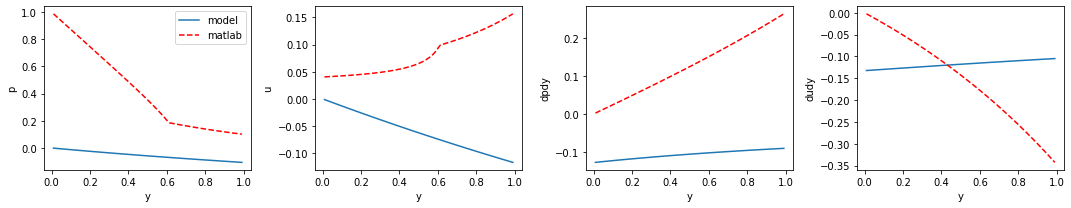

Step 1000 loss is 0.004205166362226009
u loss is 3.853713678836357e-06
p loss is 0.00018897991685662419
dudy loss is 0.0004090923466719687
dpdyloss is 0.0036032404750585556


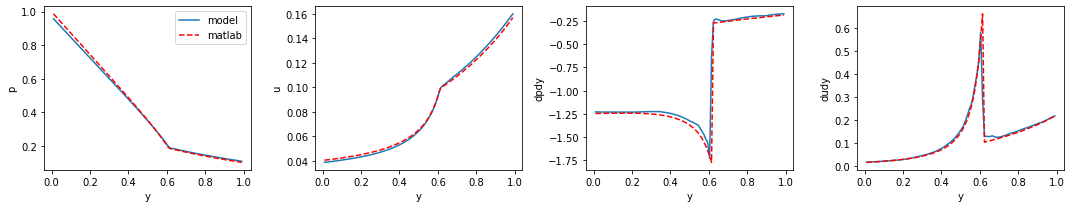

Step 2000 loss is 0.029910076409578323
u loss is 0
p loss is 0.00019280280685052276
dudy loss is 0.008209016174077988
dpdyloss is 0.02150825783610344


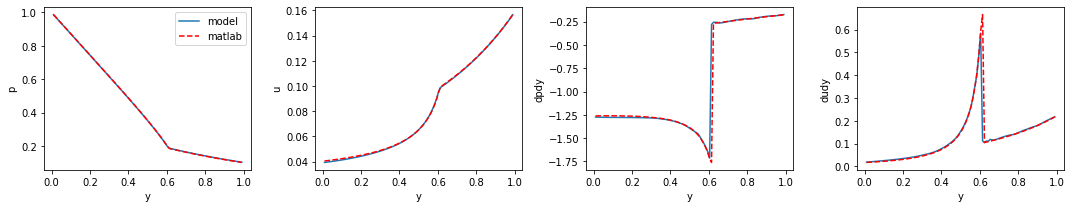

Step 3000 loss is 0.026857472956180573
u loss is 0
p loss is 0.0001315463741775602
dudy loss is 0.007092196960002184
dpdyloss is 0.01963372901082039


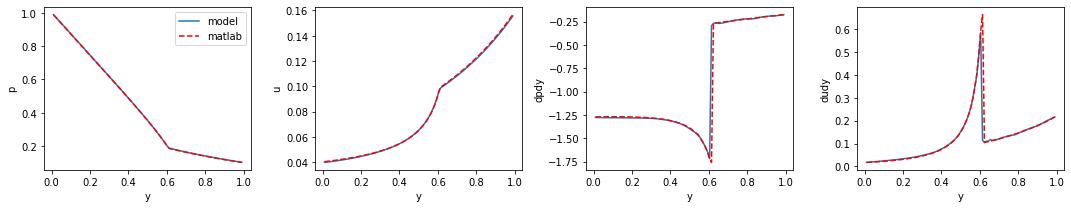

Step 4000 loss is 0.02659144625067711
u loss is 0
p loss is 0.00015865801833570004
dudy loss is 0.0070593892596662045
dpdyloss is 0.019373398274183273


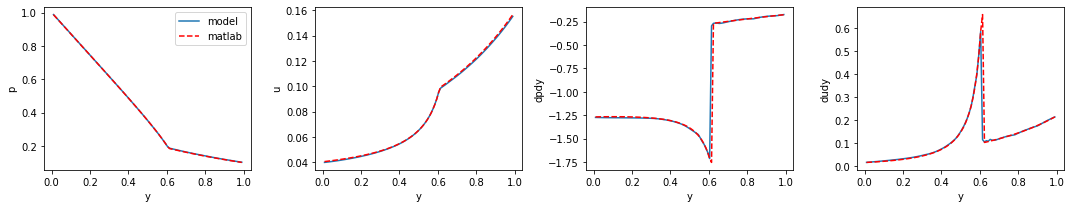

Step 5000 loss is 0.02560279704630375
u loss is 0
p loss is 0.00016287861217278987
dudy loss is 0.006900536362081766
dpdyloss is 0.01853938214480877


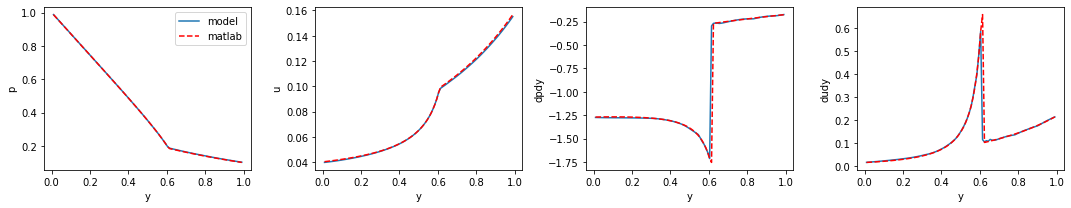

Step 6000 loss is 0.026555191725492477
u loss is 0
p loss is 0.0001655092346481979
dudy loss is 0.007147126365453005
dpdyloss is 0.019242556765675545


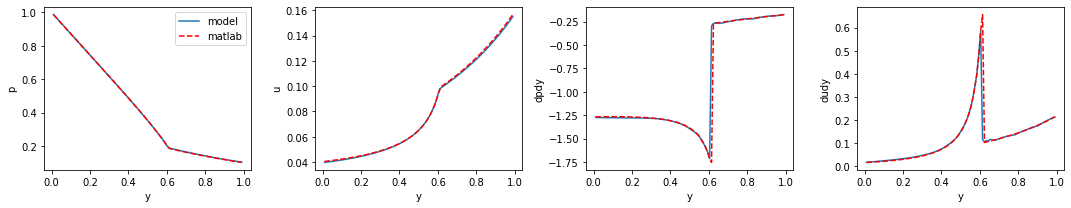

Step 7000 loss is 0.025971898809075356
u loss is 0
p loss is 0.00016553841123823076
dudy loss is 0.007052469067275524
dpdyloss is 0.018753891810774803


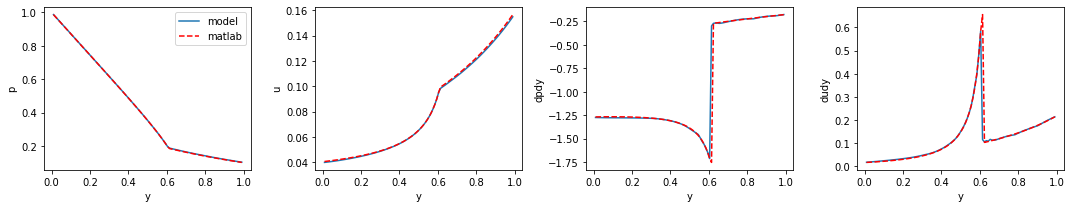

Step 8000 loss is 0.02638380229473114
u loss is 0
p loss is 0.00016316463006660342
dudy loss is 0.007153945509344339
dpdyloss is 0.019066693261265755


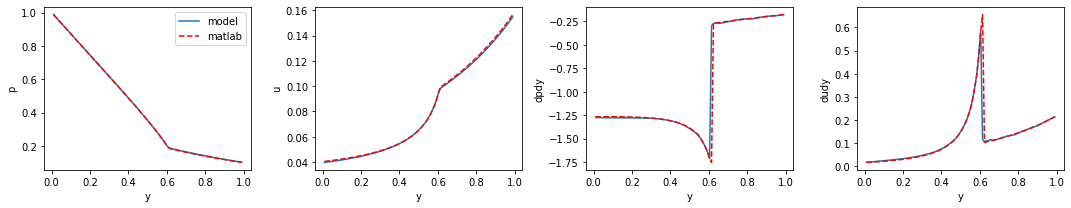

Step 9000 loss is 0.02661558985710144
u loss is 0
p loss is 0.00016106778639368713
dudy loss is 0.007210191339254379
dpdyloss is 0.019244331866502762


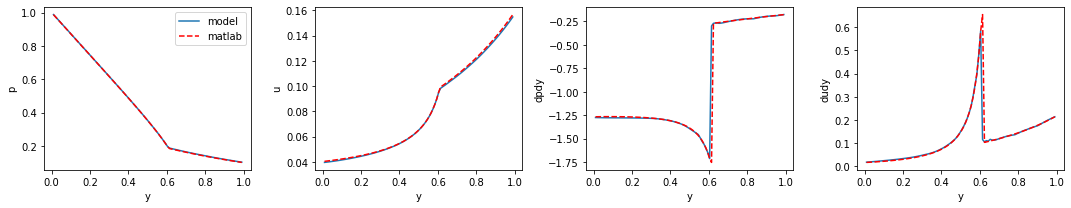

Step 10000 loss is 0.026862099766731262
u loss is 0
p loss is 0.00015977612929418683
dudy loss is 0.007269663270562887
dpdyloss is 0.019432660192251205


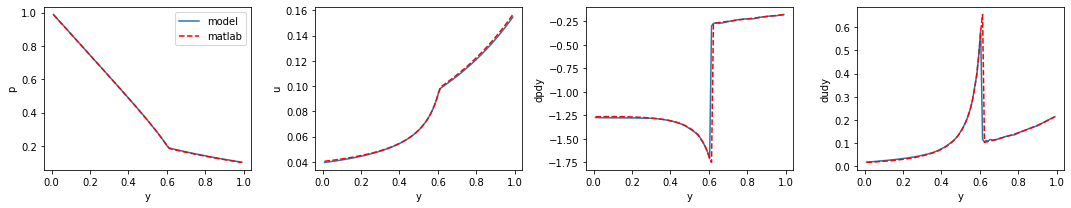

Step 11000 loss is 0.02695470117032528
u loss is 0
p loss is 0.0001584280835231766
dudy loss is 0.007296851370483637
dpdyloss is 0.01949942111968994


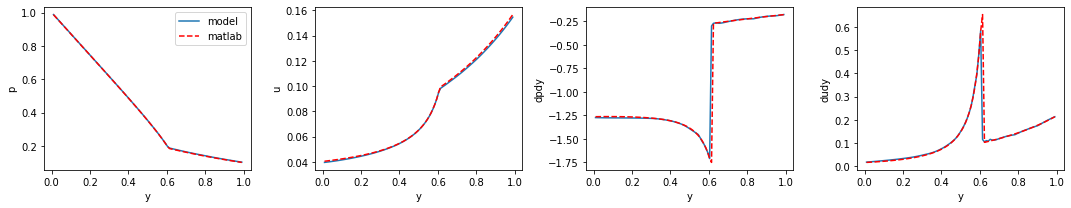

Step 12000 loss is 0.027327097952365875
u loss is 0
p loss is 0.00015651022840756923
dudy loss is 0.00738088833168149
dpdyloss is 0.019789699465036392


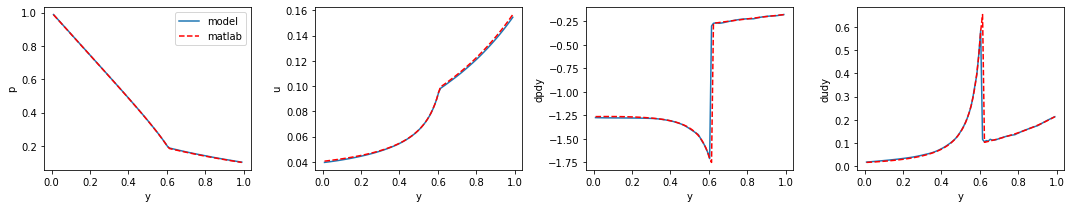

Step 13000 loss is 0.02744859829545021
u loss is 0
p loss is 0.00015430344501510262
dudy loss is 0.007411349564790726
dpdyloss is 0.019882945343852043


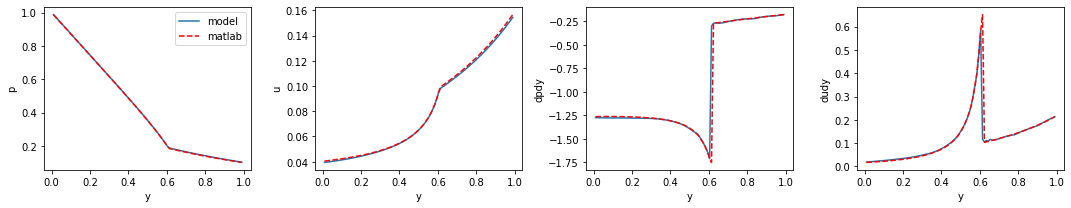

Step 14000 loss is 0.027510805055499077
u loss is 0
p loss is 0.0001508255663793534
dudy loss is 0.007412979379296303
dpdyloss is 0.019946999847888947


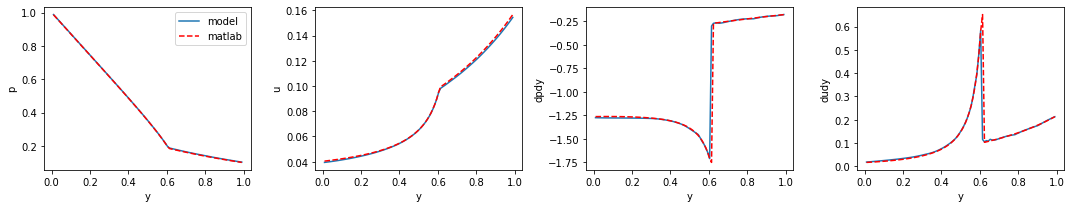

Step 15000 loss is 0.027611400932073593
u loss is 0
p loss is 0.00014758837642148137
dudy loss is 0.007419579196721315
dpdyloss is 0.0200442336499691


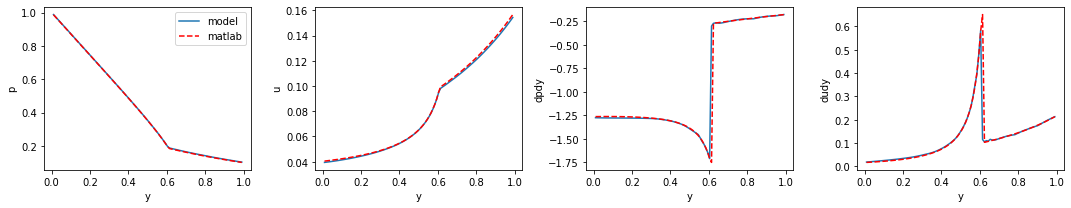

Step 16000 loss is 0.02757314033806324
u loss is 0
p loss is 0.00014465031563304365
dudy loss is 0.0073967804200947285
dpdyloss is 0.020031709223985672


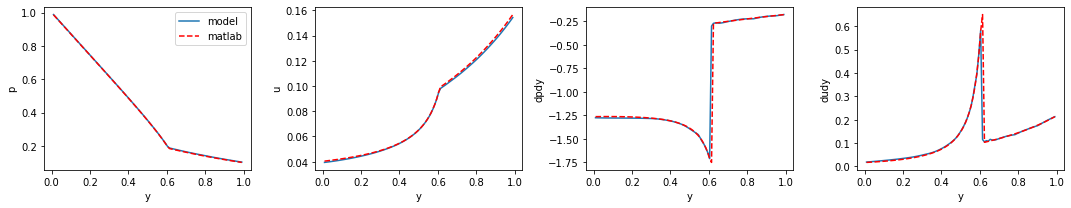

KeyboardInterrupt: 

In [23]:
conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS) # First output is pressure, second is u
train(conduit_nn, y_tensor, A, mat, simple_conduit_loss)
